In [5]:
import re

import pandas as pd
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from utils import calc_metrics

In [6]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### N-граммы плюс Naive Bayes

Попробуем решить задачу с помощью алгоритма Naive Bayes, подберем оптимальные значения для параметра `ngram_range` и обучим лучшую модель.

In [7]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [9]:
auc = []
for start in tqdm(range(1, 10)):
    for stop in range(start, min(10, start + 4)):
        vectorizer = CountVectorizer(
            preprocessor=preprocessor,
            ngram_range=(start, stop)
        )
        bow_ngram = vectorizer.fit_transform(X.release)
        auc.append(
            (
                calc_metrics(
                bow_ngram, y,
                MultinomialNB, 
                name='MultinomialNB',
                plot=False
            ), 
            (start, stop)
            
            ),
        )
    
(roc_auc, best_model), (start, stop) = max(auc, key=lambda x: x[0][0])

print(f"Лучшая модель - ngram_range({start}, {stop})")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 9/9 [43:13<00:00, 288.18s/it]

Лучшая модель - ngram_range(3, 6)
ROC-AUC = 0.7729945341838965


In [ ]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=(start, stop)
)

vectorizer.fit(X.release)

bow_ngram = vectorizer.transform(X.release)

              precision    recall  f1-score   support

        -1.0       0.68      0.83      0.75        23
         0.0       0.56      0.42      0.48        24
         1.0       0.65      0.68      0.67        19

    accuracy                           0.64        66
   macro avg       0.63      0.64      0.63        66
weighted avg       0.63      0.64      0.62        66



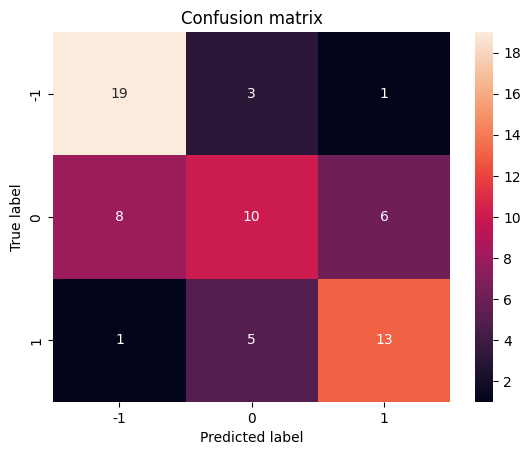

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872
MultinomialNB,0.636364,0.629318,0.628042,0.642321,0.772995


In [ ]:
metric, model = calc_metrics(bow_ngram, MultinomialNB, name='MultinomialNB')
metrics = pd.concat((metrics, metric))
metrics

Получили качество даже хуже чем минимальный безлайн.

In [10]:
metrics.to_csv('metrics.csv')